In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
# Load dataset
file_path = "./dataset.csv"
df = pd.read_csv(file_path)


In [3]:
# Check for missing values and drop if necessary
df = df.dropna(subset=['text', 'label'])

In [4]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)


In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [7]:
# Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [8]:
# Create dataset objects
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [9]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [11]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Changed from evaluation_strategy
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none" # Explicitly disable reporting to any platform, including wandb
)

In [12]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.418400,0.277637,0.903754,0.904743,0.908065,0.903754
2,0.202500,0.422007,0.898941,0.899069,0.900610,0.898941
3,0.068600,0.479019,0.909528,0.909537,0.909662,0.909528


TrainOutput(global_step=1560, training_loss=0.22364934438314193, metrics={'train_runtime': 1441.3056, 'train_samples_per_second': 8.648, 'train_steps_per_second': 1.082, 'total_flos': 3279708751979520.0, 'train_loss': 0.22364934438314193, 'epoch': 3.0})

In [14]:
# Evaluate
trainer.evaluate()

{'eval_loss': 0.47901928424835205,
 'eval_accuracy': 0.9095283926852743,
 'eval_f1': 0.9095372586200228,
 'eval_precision': 0.9096620885820957,
 'eval_recall': 0.9095283926852743,
 'eval_runtime': 30.7732,
 'eval_samples_per_second': 33.763,
 'eval_steps_per_second': 4.224,
 'epoch': 3.0}

In [15]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))
print("Label distribution:", pd.Series(test_labels).value_counts())


Train size: 4155
Test size: 1039
Label distribution: 1    526
0    490
2     23
Name: count, dtype: int64


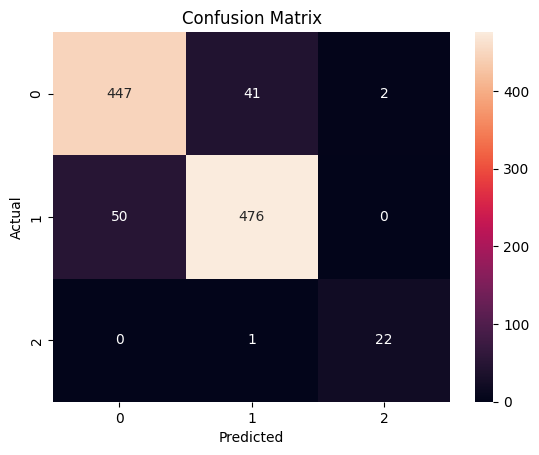

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
